In [12]:
import torch
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import Counter
from torch import nn, optim
from config import config
from net import load_model
from Dataset.utils import *
from train import train

In [2]:
model, cfg = load_model(config, num_classes=15, path='model/weights/model_40_epochs.pt', freeze=True)

In [4]:
dl = load_test_data('../../data/test')

In [5]:
out = model(next(iter(dl))[0])

/home/stephene450/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
boxes = out[0]['instances']._fields['pred_boxes'][:7].tensor

In [17]:
good_boxes = out[0]['instances']._fields['scores'] > .5
boxes = out[0]['instances']._fields['pred_boxes'].tensor[good_boxes]
classes = out[0]['instances']._fields['pred_classes'][good_boxes]
boxes

tensor([[368.4669, 239.8311, 483.1582, 310.9417]])

In [71]:
from collections import Counter
rec = 0
total = 0
for inp, gt, img in dl:
    out = model(inp)
    gt = gt[0]
    gt = gt[gt[:,-1] > -1]
    good_boxes = out[0]['instances']._fields['scores'] > .4
    pred_boxes = out[0]['instances']._fields['pred_boxes'].tensor[good_boxes].cpu()#.numpy()
    pred_classes = out[0]['instances']._fields['pred_classes'][good_boxes].cpu()#.numpy()
    total += len(gt)
    try:
        boxes, classes = remove_extra_boxes(pred_boxes, pred_classes)
        pred_classes = pred_classes.numpy()
        true_classes = Counter(gt[:,-1].numpy())
        for c in pred_classes:
            if c in true_classes and true_classes[c] > 0:
                true_classes[c] -= 1
        rec += sum(true_classes.values())
    except:
        continue # if error, it means that no boxes predicted
print(1 - rec / total)   

0.8680851063829788


In [25]:
def remove_extra_boxes(boxes, classes):
    good_boxes, good_classes = [], []
    for box, c in zip(boxes, classes):
        if not_repeat(box, good_boxes):
            good_boxes.append(box), good_classes.append(c)
    return torch.stack(good_boxes), torch.stack(good_classes)
        
def not_repeat(box, boxes, threshold=.7):
    for b in boxes:
        if iou_pytorch(box, b) > threshold:
            return False
    return True
        
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs_area = (outputs[2] - outputs[0]) * (outputs[3] - outputs[1])
    labels_area = (labels[2] - labels[0]) * (labels[3] - labels[1])
    
    # get area of intersection
    mins = torch.maximum(outputs[:2], labels[:2])
    maxs = torch.minimum(outputs[2:], labels[2:])
    intersection = (maxs[0] - mins[0]) * (maxs[1] - mins[1])
    union = outputs_area + labels_area - intersection
    return intersection / union

In [5]:
def predict(image_path, model):
    split = image_path.split('/')
    fname = split[-1]
    path = '/'.join(split[:-1])
    ds = OktoberfestDataset([fname], path, inference=True)
    img, orig = ds[0]
    img = img.unsqueeze(0)
    model.eval()
    out = model(img)
    return orig, out

In [7]:
image, out = predict('../../data/test/1526680458785_20.jpg', model)

In [22]:
def remove_extra_boxes(boxes, classes):
    good_boxes, good_classes = [], []
    for box, c in zip(boxes, classes):
        if not_repeat(box, good_boxes):
            good_boxes.append(box), good_classes.append(c)
    return torch.stack(good_boxes), torch.stack(good_classes)
        
def not_repeat(box, boxes):
    for b in boxes:
        print(iou_pytorch(box, b))
        if iou_pytorch(box, b) > .8:
            return False
    return True
        
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs_area = (outputs[2] - outputs[0]) * (outputs[3] - outputs[1])
    labels_area = (labels[2] - labels[0]) * (labels[3] - labels[1])
    
    # get area of intersection
    mins = torch.maximum(outputs[:2], labels[:2])
    maxs = torch.minimum(outputs[2:], labels[2:])
    intersection = (maxs[0] - mins[0]) * (maxs[1] - mins[1])
    union = outputs_area + labels_area - intersection
    return intersection / union

good_boxes = out[0]['instances']._fields['scores'] > .4
pred_boxes = out[0]['instances']._fields['pred_boxes'].tensor[good_boxes].cpu()#.numpy()
pred_classes = out[0]['instances']._fields['pred_classes'][good_boxes].cpu()

Without removing high IOU objects, this is the output.

2 red
3 blue
3 green


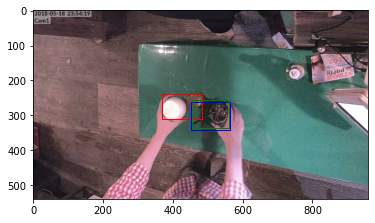

In [20]:
fig, ax = plt.subplots()
ax.imshow(image)
colors = ['red', 'blue', 'green']
for box, c, color in zip(pred_boxes, pred_classes, colors):
    print(int(c), color)
    patch = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], edgecolor=color, facecolor='none')
    ax.add_patch(patch)

This is with removing the shared high IOU

2 red
3 blue


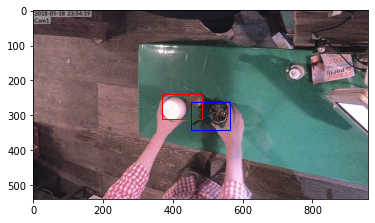

In [26]:
boxes, classes = remove_extra_boxes(pred_boxes, pred_classes)
fig, ax = plt.subplots()
ax.imshow(image)
colors = ['red', 'blue', 'green']
for box, c, color in zip(boxes, classes, colors):
    print(int(c), color)
    patch = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], edgecolor=color, facecolor='none')
    ax.add_patch(patch)